# Semantic segmentation using U-Net convolutional encoder-decoder (1st round)

# Treament description

## Semantic segmentation
The main steps are:
1. the dataset is divided into [train, test and validation sets](#data_splitting_2)
2. the semantic segmentation model is realized using a Keras convolutional encoder-decoder ([U-Net](#unet_def) for this first version)
3. the training process is monitored to check the quality of the model according to [different measures](#unet_eval)
4. as [test](#unet_test), some original images (and their corresponding generated and predicted mask) from the test set are displayed
5. the final model is used to add a [crack mask](#crack_detection_2) on larger pictures using cropping.

## Mask generation with 1st U-Net semantic segmentation
The file format for semantic segmentation must be {image, mask}, the [masks are constructed](#mask_generation_2) simply using the predictions made with the first U-net.

## Packages, data & functions
### Import Packages

In [1]:
import os
cwd = os.getcwd()
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from keras.preprocessing import image
# Define function to plot some images
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import cv2
from PIL import Image

#Mixed precision is useful if compute capability > 7
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from numpy.random import seed
seed(42)
tf.keras.utils.set_random_seed(42)

2023-06-21 09:51:00.194482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 09:51:00.569677: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-21 09:51:01.382344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-21 09:51:01.382526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


2023-06-21 09:51:02.974469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 09:51:03.052652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 09:51:03.052761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 09:51:03.053207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Overall Settings

In [2]:
TRAINING_EPOCHS = 2
FINE_TUNING_EPOCHS = 3
BATCH_SIZE = 32
unfreezing_ratio = 30

image_height = 224
image_width = 224


## Load data

In [3]:
unet_base_dir = "/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/"

unet_base_dataset = image_dataset_from_directory(
    unet_base_dir,
    labels=None,
    image_size = (image_height, image_width),
    crop_to_aspect_ratio = True,
    shuffle = False,
    batch_size = 1)

Found 120000 files belonging to 1 classes.


2023-06-21 09:51:10.291708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 09:51:10.293547: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 09:51:10.293620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-21 09:51:10.293659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [4]:
unet_base_df = pd.DataFrame(unet_base_dataset.file_paths.copy())
unet_base_df.columns = ['unet_fullpaths_image']
unet_base_df[['unet_fullpaths_mask']] = unet_base_df[['unet_fullpaths_image']]
unet_base_df['unet_fullpaths_mask'] = unet_base_df.apply(lambda x: str(x.unet_fullpaths_image).replace('image', 'mask'), axis=1)

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
display(unet_base_df)

unet_fullpaths_image  \
0        /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00001.jpg   
1        /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00002.jpg   
2        /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00003.jpg   
3        /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00004.jpg   
4        /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00005.jpg   
...                                                                                                      ...   
119995  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19996.jpg   
119996  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19997.jpg   
119997  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19998.jpg   
119998  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19999.jpg   
119999  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_20000.jpg   

                                                                                         unet_fullpaths_mask  
0         /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00001.jpg  
1         /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00002.jpg  
2         /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00003.jpg  
3         /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00004.jpg  
4         /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00005.jpg  
...                                                                                                      ...  
119995  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19996.jpg  
119996  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19997.jpg  
119997  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19998.jpg  
119998  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_19999.jpg  
119999  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask_2/p_20000.jpg  

[120000 rows x 2 columns]

In [7]:
unet_base_df['unet_fullpaths_image'].str.contains("mask")

0         False
1         False
2         False
3         False
4         False
          ...  
119995     True
119996     True
119997     True
119998     True
119999     True
Name: unet_fullpaths_image, Length: 120000, dtype: bool

In [8]:
unet_base_df = unet_base_df[~unet_base_df['unet_fullpaths_image'].str.contains("mask")]

In [9]:
display(unet_base_df)

unet_fullpaths_image  \
0      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00001.jpg   
1      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00002.jpg   
2      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00003.jpg   
3      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00004.jpg   
4      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_00005.jpg   
...                                                                                                    ...   
39995  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_19996.jpg   
39996  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_19997.jpg   
39997  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_19998.jpg   
39998  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_19999.jpg   
39999  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_20000.jpg   

                                                                                      unet_fullpaths_mask  
0      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00001.jpg  
1      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00002.jpg  
2      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00003.jpg  
3      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00004.jpg  
4      /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_00005.jpg  
...                                                                                                   ...  
39995  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_19996.jpg  
39996  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_19997.jpg  
39997  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_19998.jpg  
39998  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_19999.jpg  
39999  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_20000.jpg  

[40000 rows x 2 columns]

<a id="data_splitting_2"></a>
## Split data

In [10]:
# 60% - train set,
# 20% - validation set,
# 20% - test set

unet_train_df, unet_valid_df, unet_test_df = np.split(unet_base_df.sample(frac=1, random_state=42), [int(.6*len(unet_base_df)), int(.8*len(unet_base_df))])

In [11]:
unet_valid_df

unet_fullpaths_image  \
17441    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_17442.jpg   
10156    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_10157.jpg   
7687     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_07688.jpg   
2629     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_02630.jpg   
7699     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_07700.jpg   
...                                                                                                      ...   
35414  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_15415_1.jpg   
25738    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_05739.jpg   
32713  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_12714_1.jpg   
21669    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_01670.jpg   
30702  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_10703_1.jpg   

                                                                                        unet_fullpaths_mask  
17441    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_17442.jpg  
10156    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_10157.jpg  
7687     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_07688.jpg  
2629     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_02630.jpg  
7699     /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/n_07700.jpg  
...                                                                                                     ...  
35414  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_15415_1.jpg  
25738    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_05739.jpg  
32713  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_12714_1.jpg  
21669    /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_01670.jpg  
30702  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/p_10703_1.jpg  

[8000 rows x 2 columns]

### Data Generators
<a id="data_preprocessing"></a>

For more information:
- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)


In [12]:
unet_gen = ImageDataGenerator(rescale         = 1./255.,
                              horizontal_flip = True,
                              vertical_flip   = True,
                              zoom_range      = 0.05,
                              rotation_range  = 25)
UNET_BATCH_SIZE = 1
unet_image_height = 256
unet_image_width = 256


### Data agumentation and pre-processing using tensorflow on train set

In [13]:
unet_train_generator_image = unet_gen.flow_from_dataframe(unet_train_df,
                                               directory = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/',
                                               class_mode=None,
                                               x_col = 'unet_fullpaths_image',
#                                               color_mode = "grayscale",
                                               target_size = (unet_image_height, unet_image_width), 
                                               batch_size = UNET_BATCH_SIZE,
                                               shuffle = True,
                                               seed = 42)

Found 24000 validated image filenames.


In [14]:
unet_train_generator_mask = unet_gen.flow_from_dataframe(unet_train_df,
                                               directory = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/',
                                               class_mode=None,
                                               x_col = 'unet_fullpaths_mask',
                                               color_mode = "grayscale",
                                               target_size = (unet_image_height, unet_image_width), 
                                               batch_size = UNET_BATCH_SIZE,
                                               shuffle = True,
                                               seed = 42)

Found 24000 validated image filenames.


In [15]:
def create_gens(image_gen, mask_gen):
    gen = zip(image_gen, mask_gen)
    for (img, msk) in gen:
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        yield (img, msk)

unet_train_gen = create_gens(unet_train_generator_image, unet_train_generator_mask)

### Data agumentation and pre-processing using tensorflow on test and validation sets

In [16]:
unet_test_gen = ImageDataGenerator(rescale = 1./255.)

unet_validation_generator_image = unet_test_gen.flow_from_dataframe(unet_valid_df,
                                               directory = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/',
                                               class_mode=None,
                                               x_col = 'unet_fullpaths_image',
#                                               color_mode = "grayscale",
                                               target_size = (unet_image_height, unet_image_width), 
                                               batch_size = UNET_BATCH_SIZE,
                                               shuffle = True,
                                               seed = 42)

unet_validation_generator_mask = unet_test_gen.flow_from_dataframe(unet_valid_df,
                                               directory = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/',
                                               class_mode=None,
                                               x_col = 'unet_fullpaths_mask',
                                               color_mode = "grayscale",
                                               target_size = (unet_image_height, unet_image_width), 
                                               batch_size = UNET_BATCH_SIZE,
                                               shuffle = True,
                                               seed = 42)

Found 8000 validated image filenames.
Found 8000 validated image filenames.


In [17]:
unet_validation_gen = create_gens(unet_validation_generator_image,  unet_validation_generator_mask)

In [18]:
unet_test_generator_image = unet_test_gen.flow_from_dataframe(unet_test_df,
                                               directory = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/',
                                               class_mode=None,
                                               x_col = 'unet_fullpaths_image',
#                                               color_mode = "grayscale",
                                               target_size = (unet_image_height, unet_image_width), 
                                               batch_size = UNET_BATCH_SIZE,
                                               shuffle = True,
                                               seed = 42)

unet_test_generator_mask = unet_test_gen.flow_from_dataframe(unet_test_df,
                                               directory = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/mask/',
                                               class_mode=None,
                                               x_col = 'unet_fullpaths_mask',
                                               color_mode = "grayscale",
                                               target_size = (unet_image_height, unet_image_width), 
                                               batch_size = UNET_BATCH_SIZE,
                                               shuffle = True,
                                               seed = 42)

Found 8000 validated image filenames.
Found 8000 validated image filenames.


In [19]:
unet_test_gen = create_gens(unet_test_generator_image,  unet_test_generator_mask)

<a id="unet_def"></a>
## U-Net definition

In [20]:
def unet(input_size=(unet_image_height, unet_image_width, 3)):
    inputs = Input(input_size)
    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """

    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## Useful functions

In [21]:
from tensorflow.keras import backend as K

# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou



In [22]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']
    tr_loss = hist.history['loss']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']
    val_loss = hist.history['val_loss']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    index_iou = np.argmax(val_iou)
    iou_highest = val_iou[index_iou]
    index_dice = np.argmax(val_dice)
    dice_highest = val_dice[index_dice]
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'
    iou_label = f'best epoch= {str(index_iou + 1)}'
    dice_label = f'best epoch= {str(index_dice + 1)}'
    loss_label = f'best epoch= {str(index_loss + 1)}'

    # Plot training history
    plt.figure(figsize=(10, 10))
#    plt.figure(figsize= (20, 20))
#    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    # Training Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Training IoU
    plt.subplot(2, 2, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.scatter(index_iou + 1 , iou_highest, s= 150, c= 'blue', label= iou_label)
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    # Training Dice
    plt.subplot(2, 2, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.scatter(index_dice + 1 , dice_highest, s= 150, c= 'blue', label= dice_label)
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    # Training Loss
    plt.subplot(2, 2, 4)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

#    plt.tight_layout
    plt.show()

## U-Net compilation and training

In [30]:
unet_model = unet()
unet_model.compile(tf.keras.optimizers.Adam(learning_rate= 0.0005), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])

unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 256, 256, 64  0           ['conv2d_38[0][0]']              
                                )                                                           

In [31]:
epochs = 16
batch_size = 32

# callbacks = [ModelCheckpoint('unet.hdf5', verbose=0, save_best_only=True)]
# Call backs:
# - early stopping
early = tf.keras.callbacks.EarlyStopping( monitor = "val_dice_coef",
                                          patience = 3,
                                          min_delta = 0.001,
                                          verbose=1,
                                          restore_best_weights = False)
# - tensor board
tensor_board = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# - reduce on plateau
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.1, patience=3, min_lr=0.0001)

history = unet_model.fit(unet_train_gen,
                         steps_per_epoch=len(unet_train_df) / batch_size,
                         epochs=epochs,
                         verbose=1,
                         callbacks = [early, tensor_board, reduce_lr],
                         validation_data = unet_validation_gen,
                         validation_steps=len(unet_valid_df) / batch_size)

Epoch 1/16
750/750 [==============================] - 54s 69ms/step - loss: -0.5037 - accuracy: 0.9803 - iou_coef: 0.4539 - dice_coef: 0.5036 - val_loss: -0.7973 - val_accuracy: 0.9924 - val_iou_coef: 0.7517 - val_dice_coef: 0.7973 - lr: 5.0000e-04
Epoch 2/16
750/750 [==============================] - 51s 68ms/step - loss: -0.8953 - accuracy: 0.9938 - iou_coef: 0.8513 - dice_coef: 0.8952 - val_loss: -0.8464 - val_accuracy: 0.9938 - val_iou_coef: 0.7987 - val_dice_coef: 0.8463 - lr: 5.0000e-04
Epoch 3/16
750/750 [==============================] - 51s 68ms/step - loss: -0.9103 - accuracy: 0.9955 - iou_coef: 0.8725 - dice_coef: 0.9102 - val_loss: -0.9011 - val_accuracy: 0.9960 - val_iou_coef: 0.8670 - val_dice_coef: 0.9010 - lr: 5.0000e-04
Epoch 4/16
750/750 [==============================] - 50s 66ms/step - loss: -0.8929 - accuracy: 0.9959 - iou_coef: 0.8542 - dice_coef: 0.8928 - val_loss: -0.9153 - val_accuracy: 0.9962 - val_iou_coef: 0.8799 - val_dice_coef: 0.9152 - lr: 5.0000e-04
Epoc

<a id="unet_eval"></a>
## U-Net evaluation

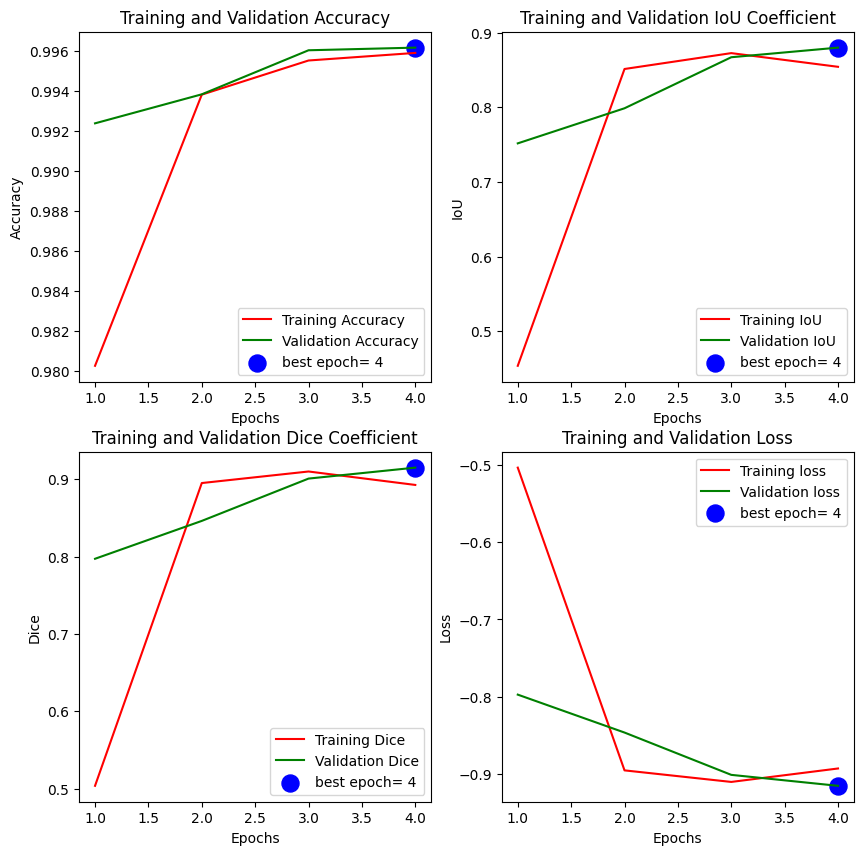

In [32]:
plt.rcParams.update(plt.rcParamsDefault)
plot_training(history)

<a id="unet_test"></a>
## U-Net testing

index =  7793
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_17505_1.jpg
1/1 [==============================] - 0s 257ms/step


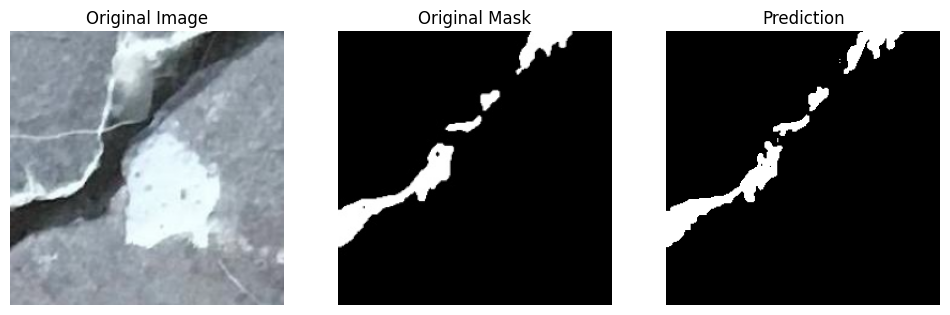

index =  3636
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_03359.jpg
1/1 [==============================] - 0s 26ms/step


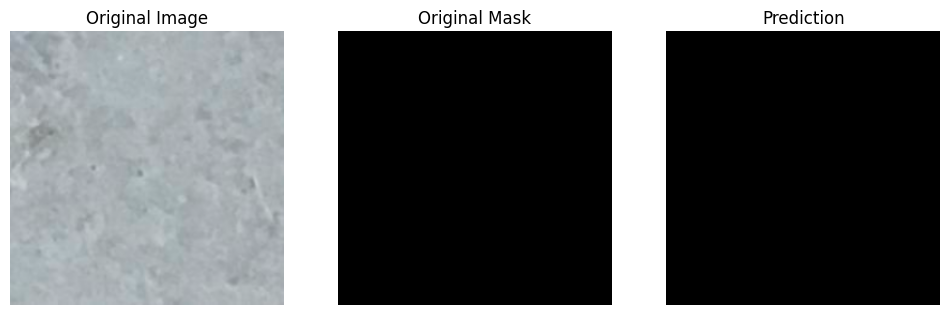

index =  4080
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_15741_1.jpg
1/1 [==============================] - 0s 28ms/step


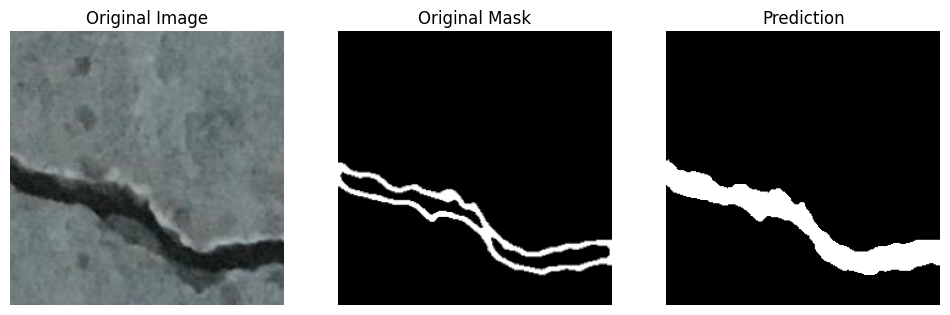

index =  3790
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_17959.jpg
1/1 [==============================] - 0s 28ms/step


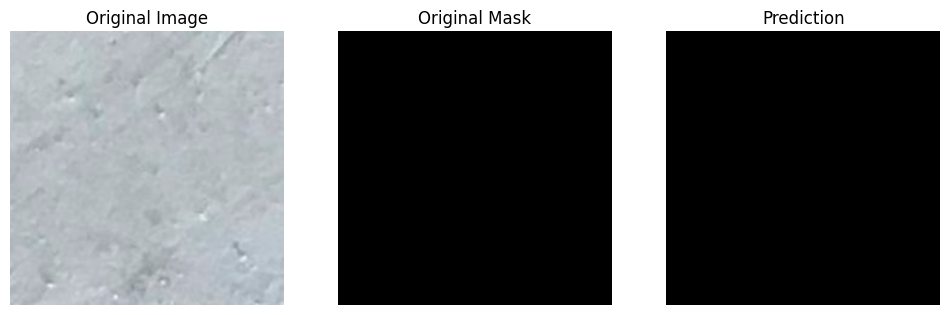

index =  5752
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_05111.jpg
1/1 [==============================] - 0s 19ms/step


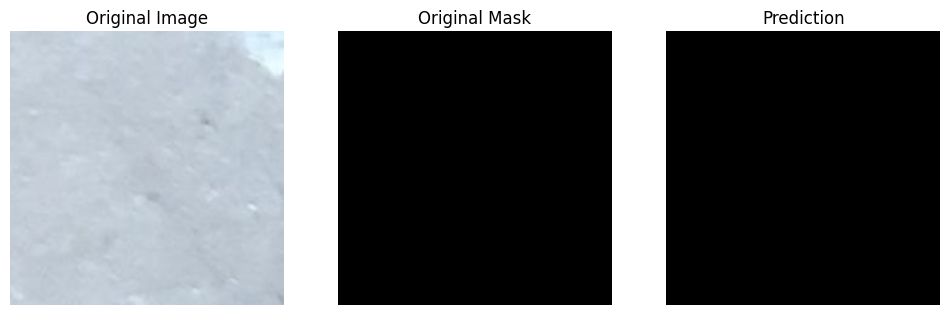

index =  6370
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_11562.jpg
1/1 [==============================] - 0s 27ms/step


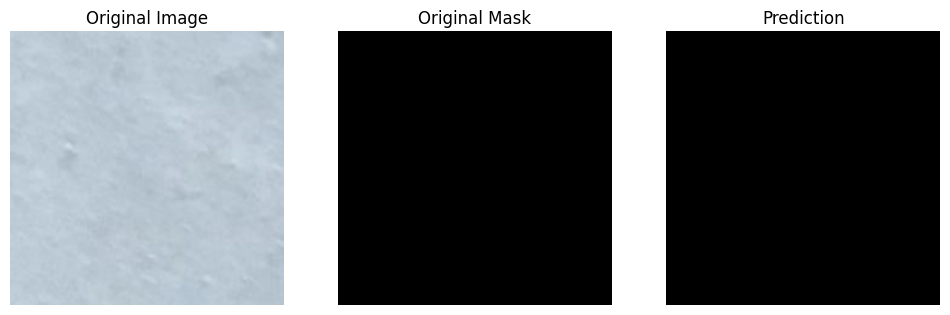

index =  413
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_08494.jpg
1/1 [==============================] - 0s 25ms/step


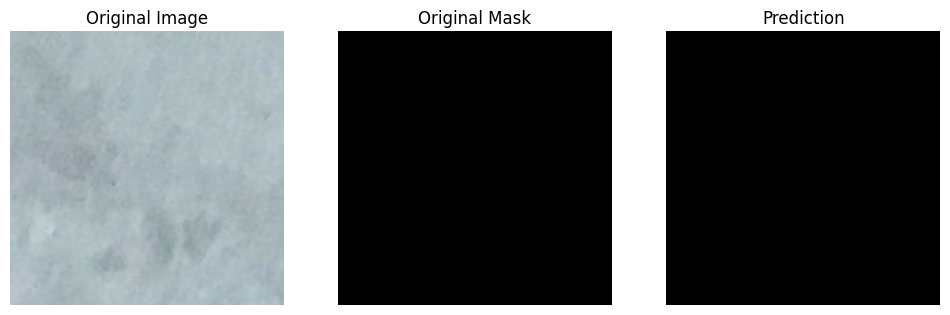

index =  7795
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_15154_1.jpg
1/1 [==============================] - 0s 23ms/step


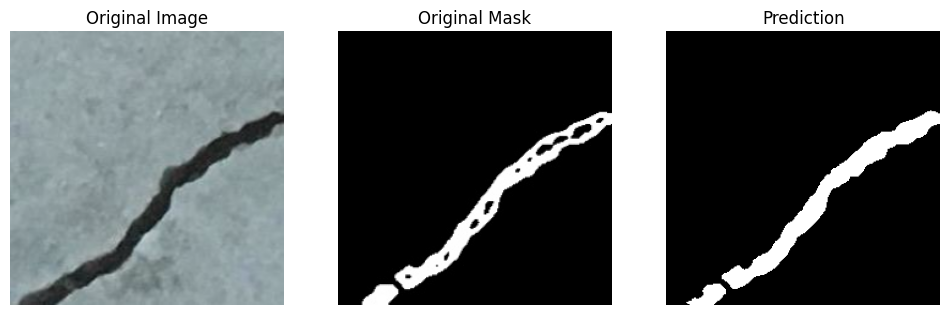

index =  4709
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_03545.jpg
1/1 [==============================] - 0s 25ms/step


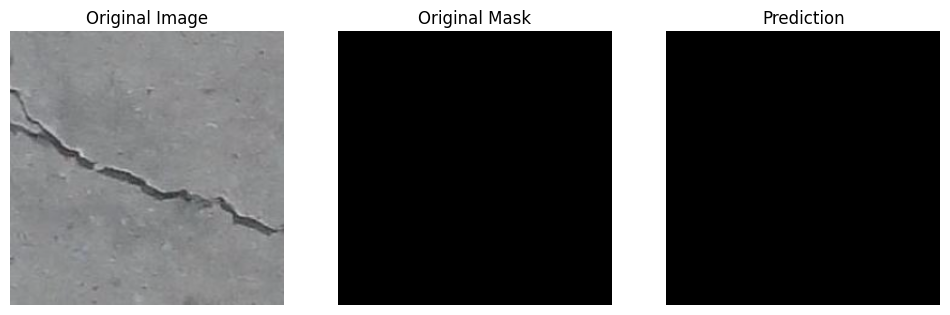

index =  6165
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_06442.jpg
1/1 [==============================] - 0s 24ms/step


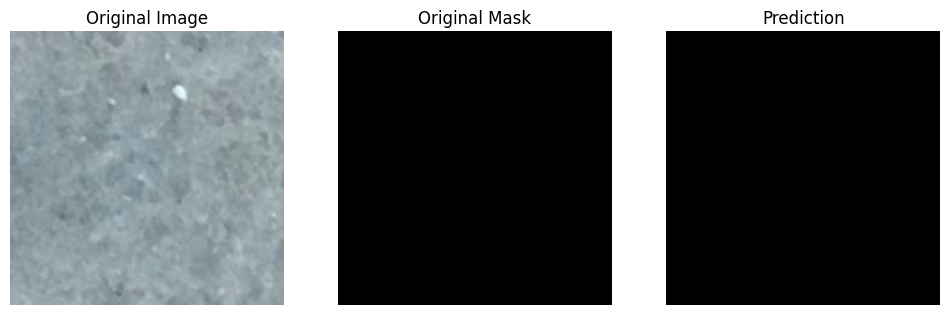

index =  911
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_08999.jpg
1/1 [==============================] - 0s 22ms/step


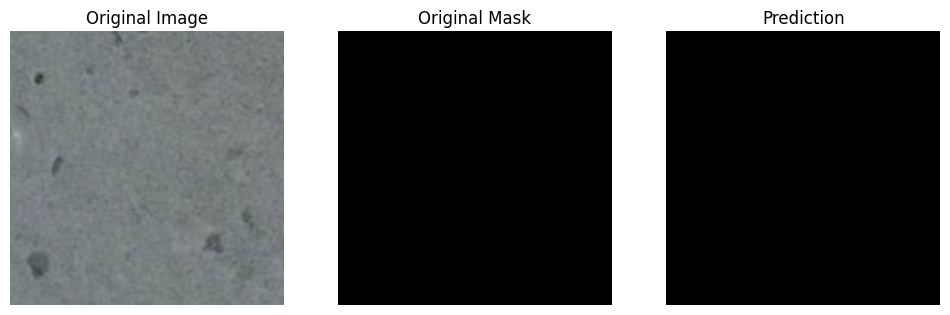

index =  1088
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_18106_1.jpg
1/1 [==============================] - 0s 31ms/step


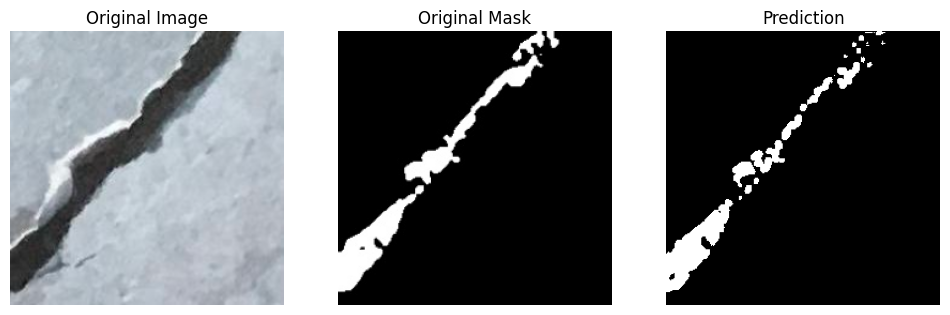

index =  6614
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_02891.jpg
1/1 [==============================] - 0s 38ms/step


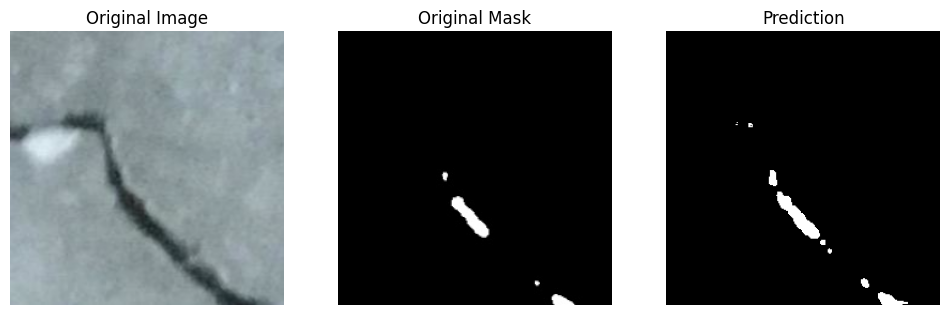

index =  3579
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_13027.jpg
1/1 [==============================] - 0s 31ms/step


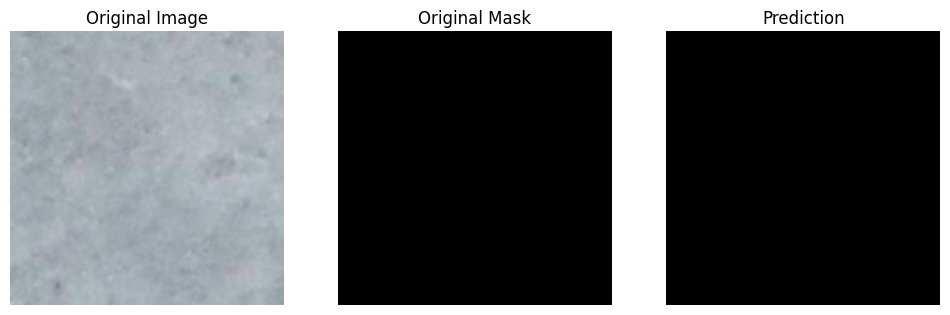

index =  5677
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_18995.jpg
1/1 [==============================] - 0s 31ms/step


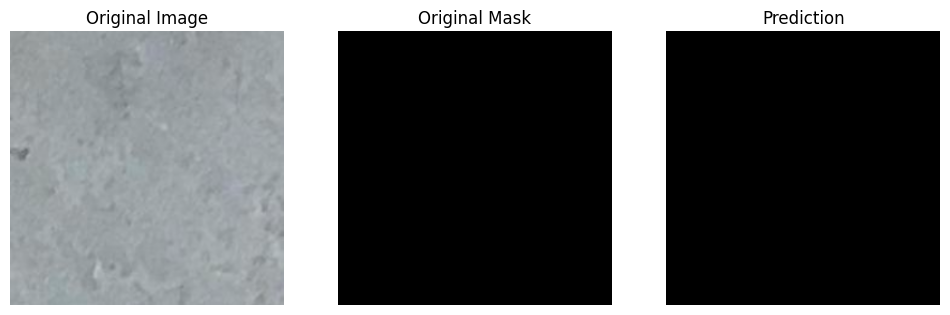

index =  7902
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_15223_1.jpg
1/1 [==============================] - 0s 34ms/step


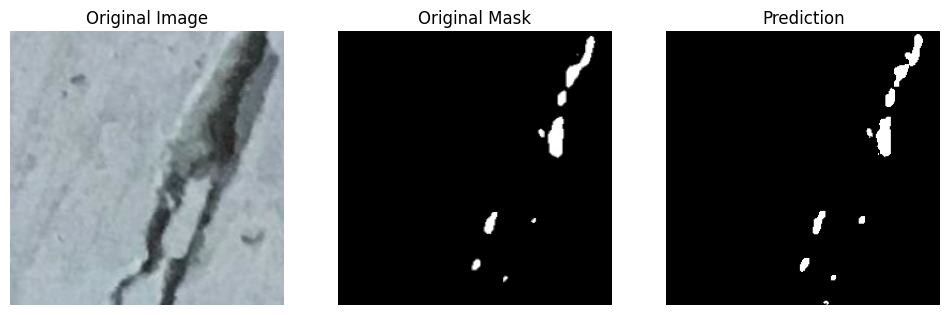

index =  6829
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_01525.jpg
1/1 [==============================] - 0s 32ms/step


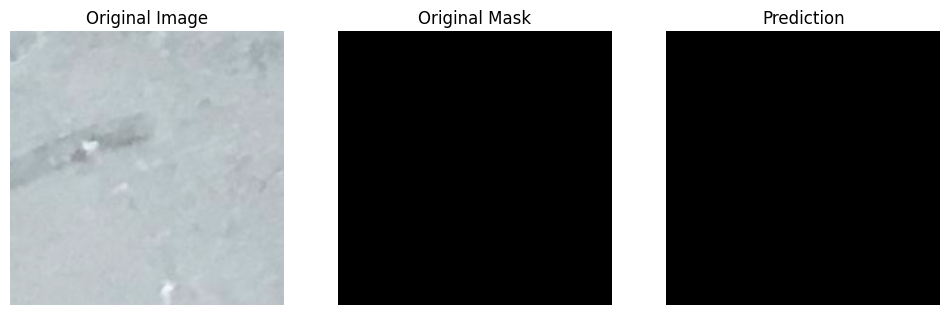

index =  7734
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_12353_1.jpg
1/1 [==============================] - 0s 50ms/step


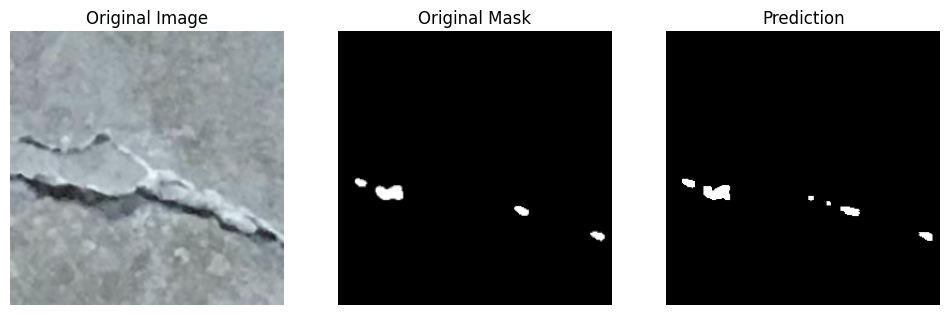

index =  4897
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_05739.jpg
1/1 [==============================] - 0s 45ms/step


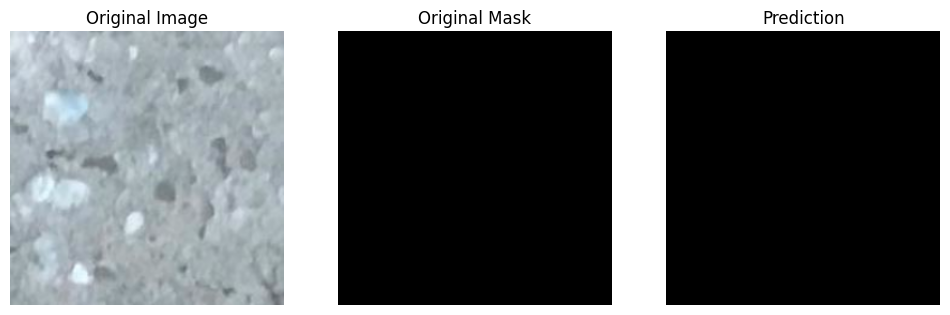

index =  6302
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_05612.jpg
1/1 [==============================] - 0s 37ms/step


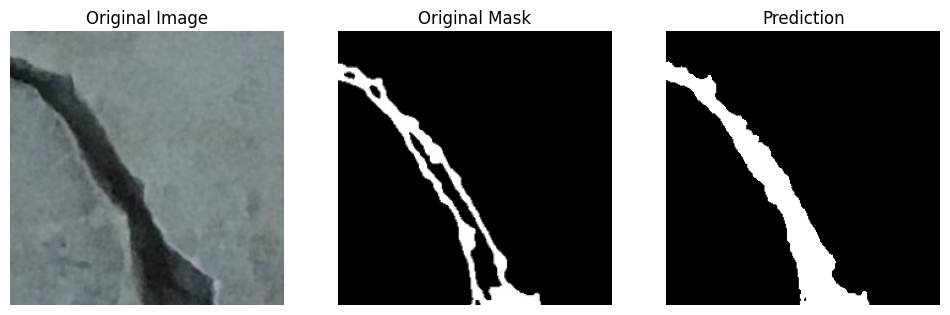

index =  880
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_01470.jpg
1/1 [==============================] - 0s 39ms/step


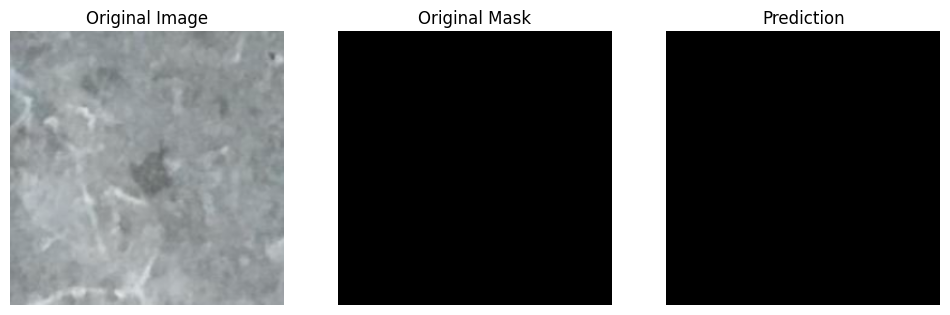

index =  6212
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_06472.jpg
1/1 [==============================] - 0s 32ms/step


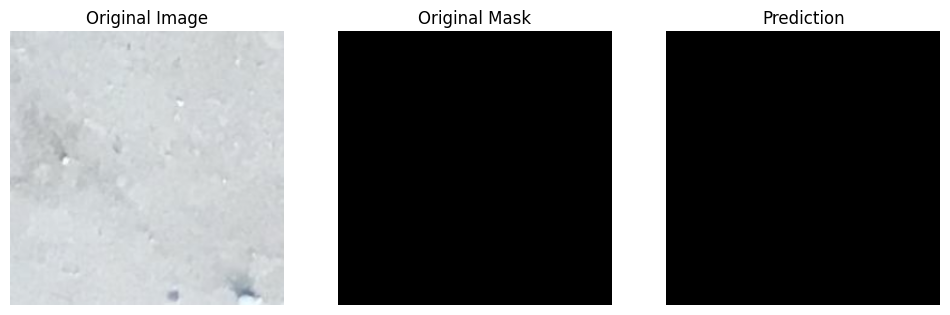

index =  5059
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_07685.jpg
1/1 [==============================] - 0s 33ms/step


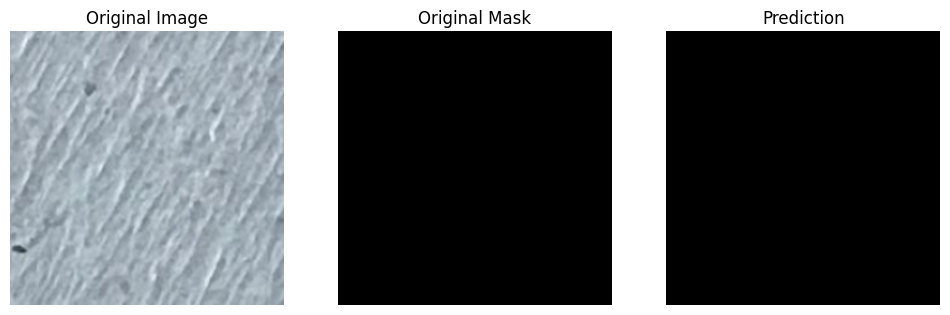

index =  916
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_18162.jpg
1/1 [==============================] - 0s 32ms/step


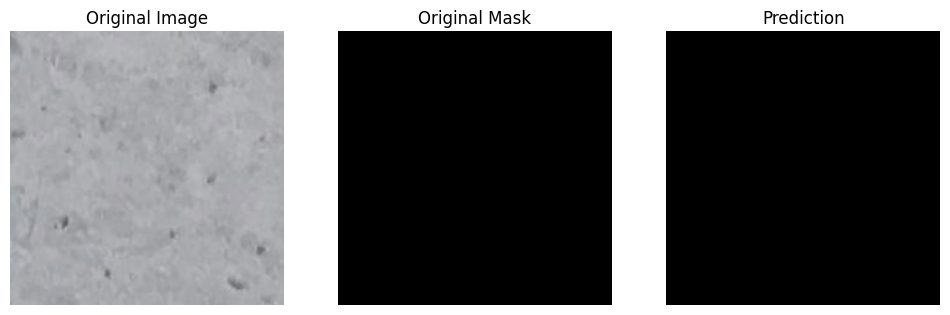

index =  3954
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_04230.jpg
1/1 [==============================] - 0s 33ms/step


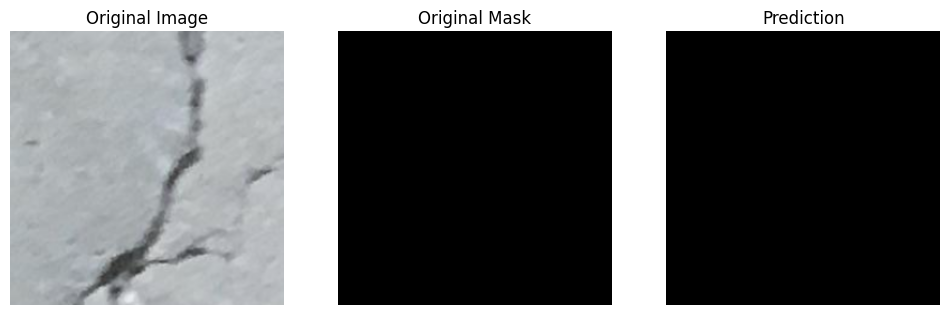

index =  7534
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_17507.jpg
1/1 [==============================] - 0s 49ms/step


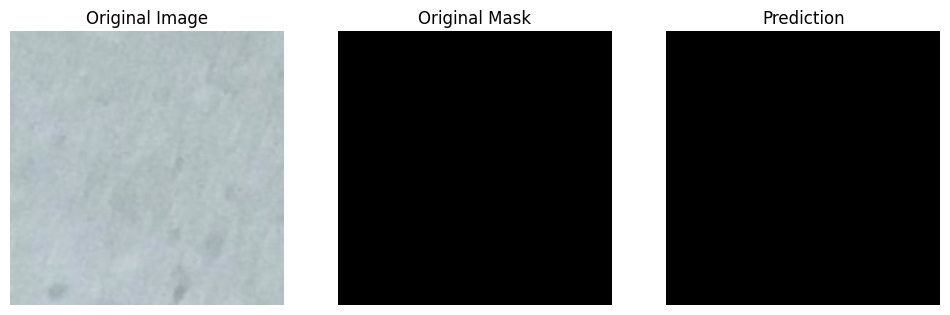

index =  5657
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_17070.jpg
1/1 [==============================] - 0s 35ms/step


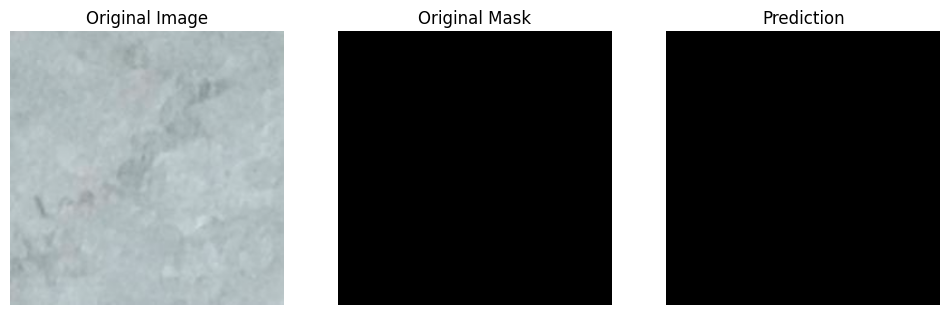

index =  2491
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_12198.jpg
1/1 [==============================] - 0s 31ms/step


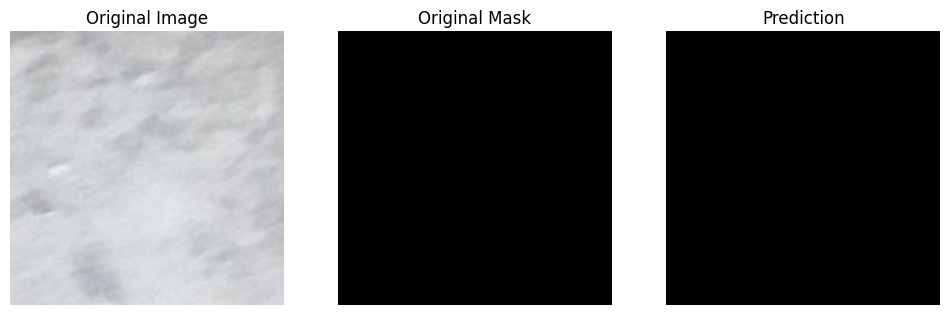

index =  1607
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_09473.jpg
1/1 [==============================] - 0s 39ms/step


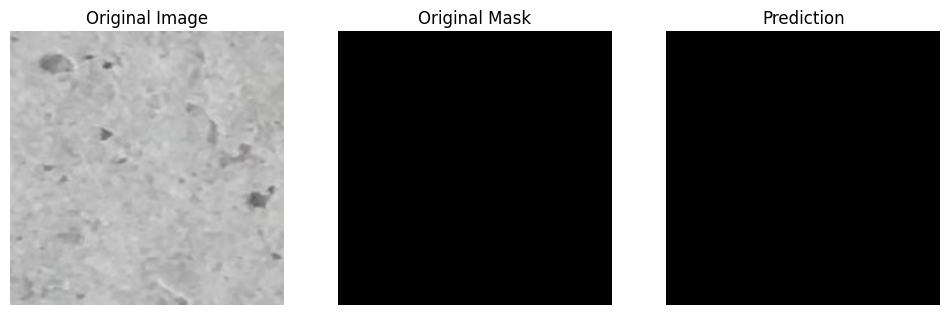

index =  2817
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_04759.jpg
1/1 [==============================] - 0s 36ms/step


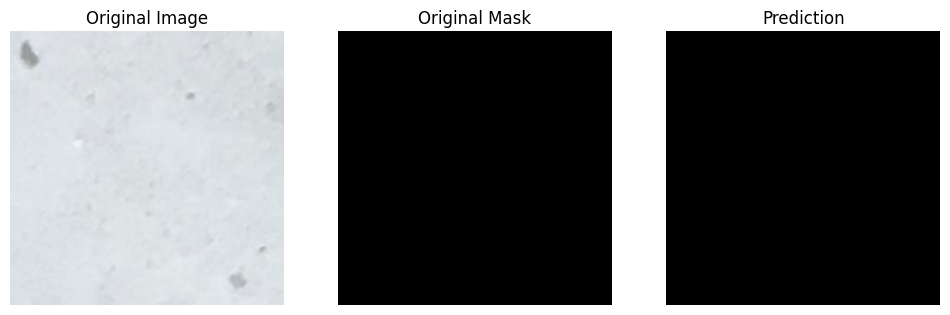

index =  2692
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_07298.jpg
1/1 [==============================] - 0s 37ms/step


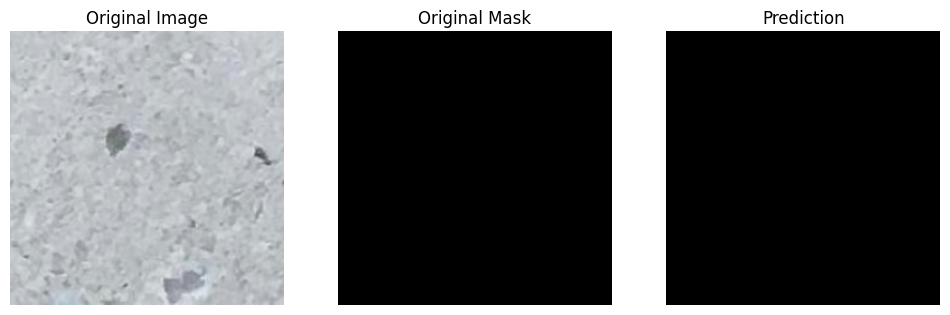

index =  7867
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_01835.jpg
1/1 [==============================] - 0s 33ms/step


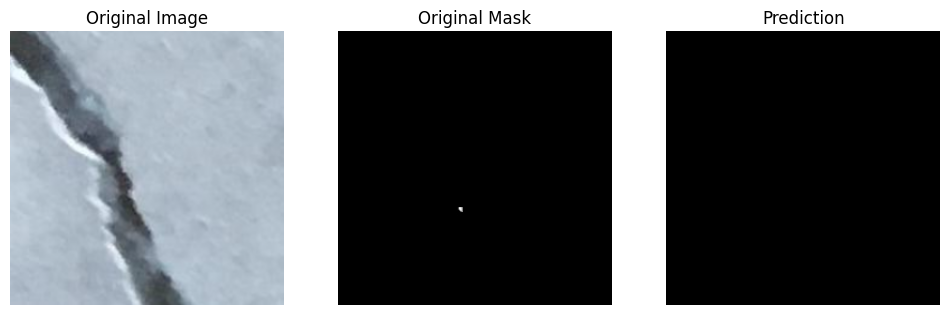

index =  4213
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_16323.jpg
1/1 [==============================] - 0s 30ms/step


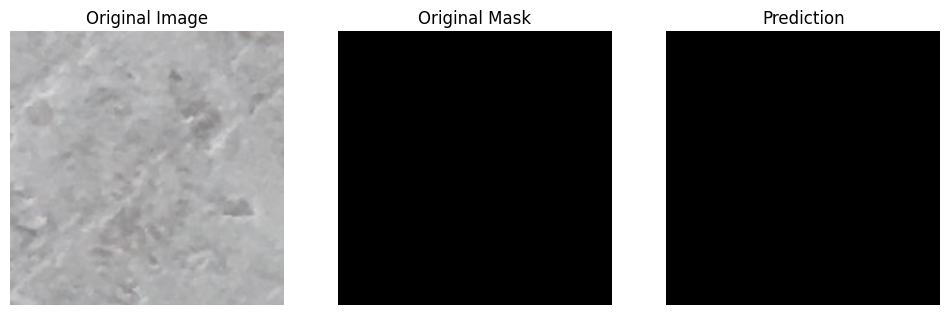

index =  4348
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_09039.jpg
1/1 [==============================] - 0s 25ms/step


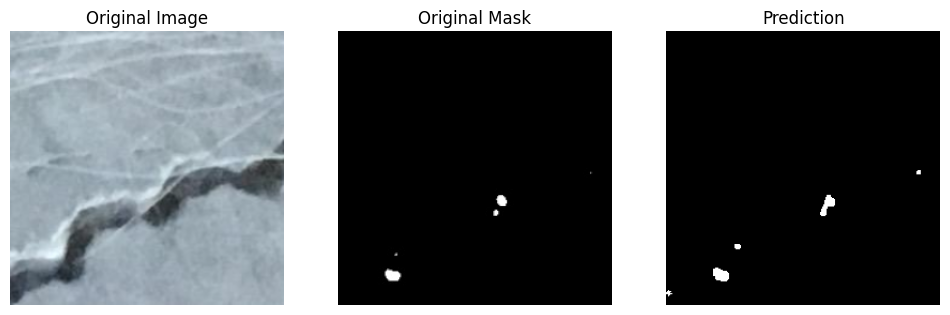

index =  2189
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_03332.jpg
1/1 [==============================] - 0s 37ms/step


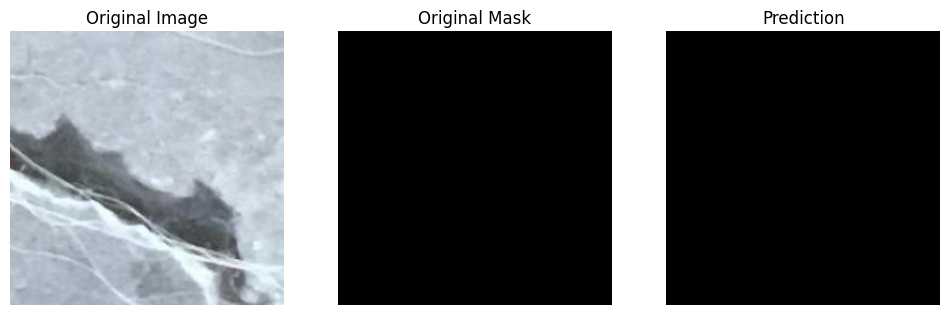

index =  1571
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_12447.jpg
1/1 [==============================] - 0s 29ms/step


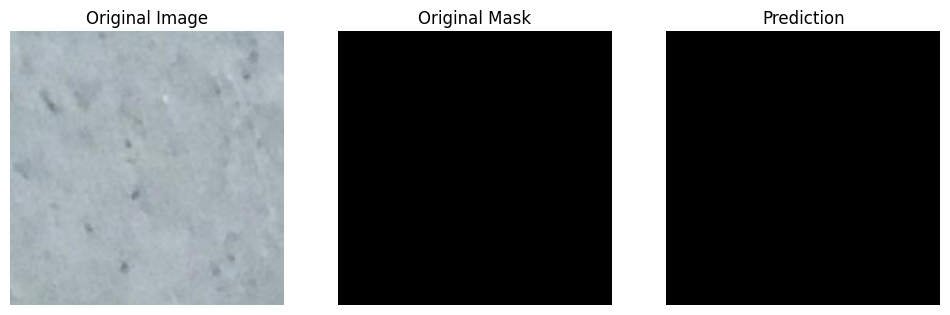

index =  2636
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_03475.jpg
1/1 [==============================] - 0s 30ms/step


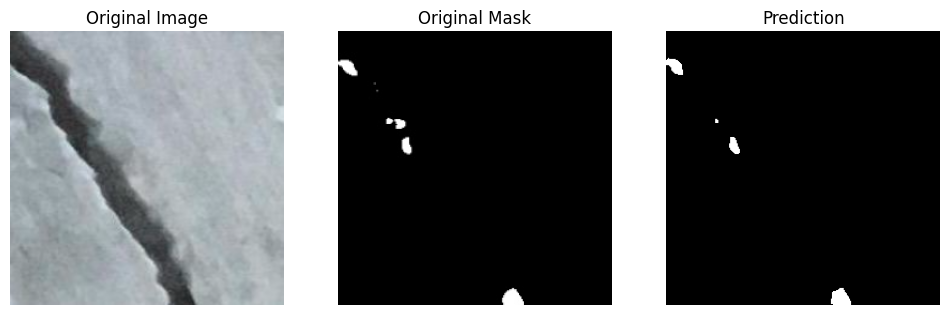

index =  4823
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_16610_1.jpg
1/1 [==============================] - 0s 48ms/step


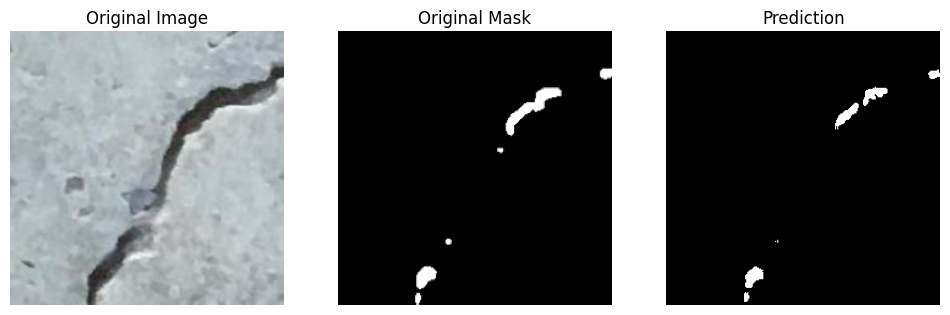

index =  266
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_03202.jpg
1/1 [==============================] - 0s 46ms/step


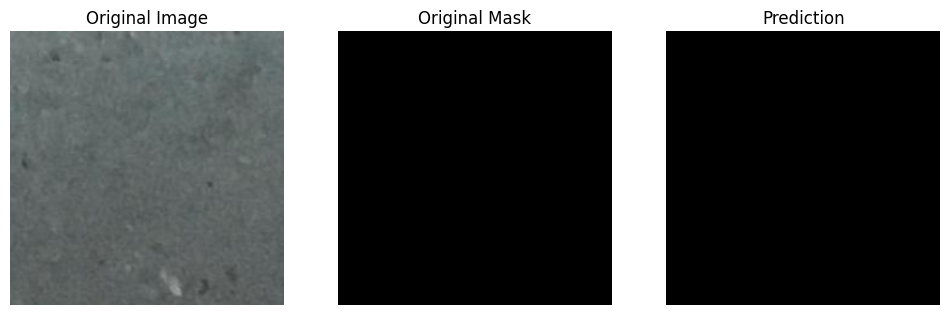

index =  2537
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_03489.jpg
1/1 [==============================] - 0s 21ms/step


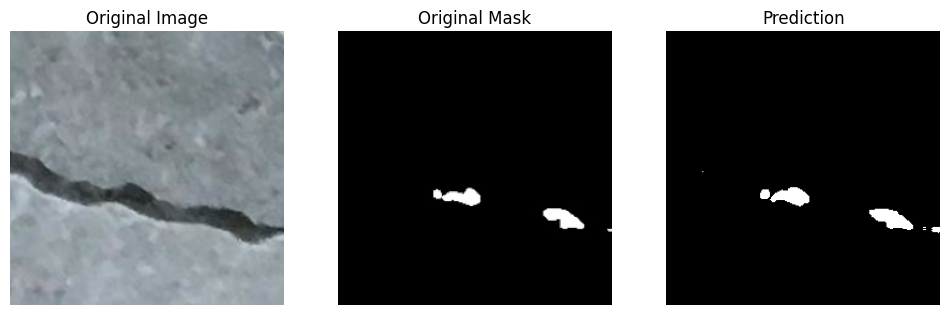

index =  1304
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_06121.jpg
1/1 [==============================] - 0s 31ms/step


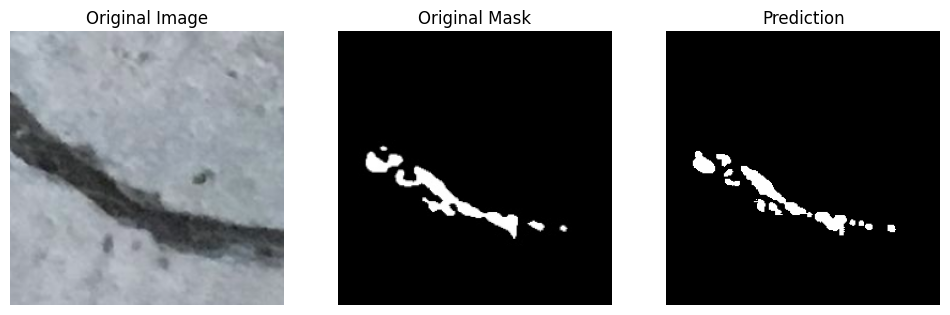

index =  2129
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_04919.jpg
1/1 [==============================] - 0s 32ms/step


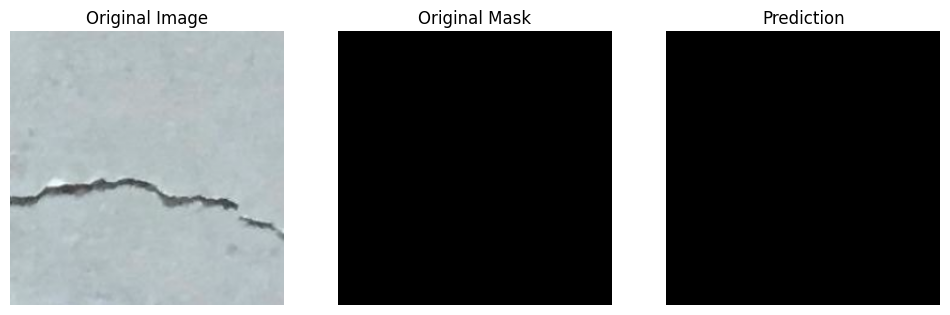

index =  2386
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_12862.jpg
1/1 [==============================] - 0s 30ms/step


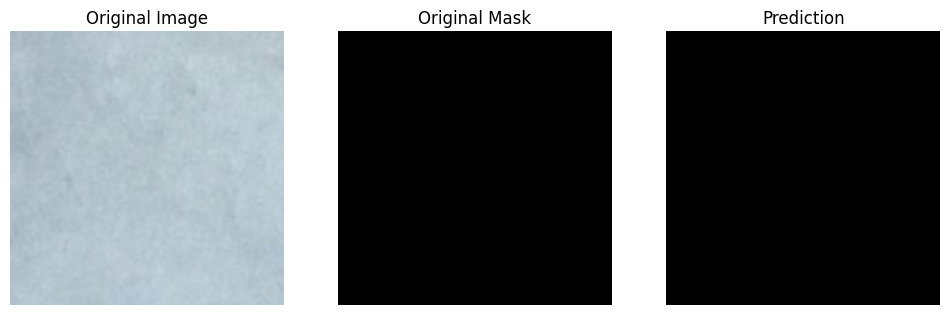

index =  2949
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_15302_1.jpg
1/1 [==============================] - 0s 29ms/step


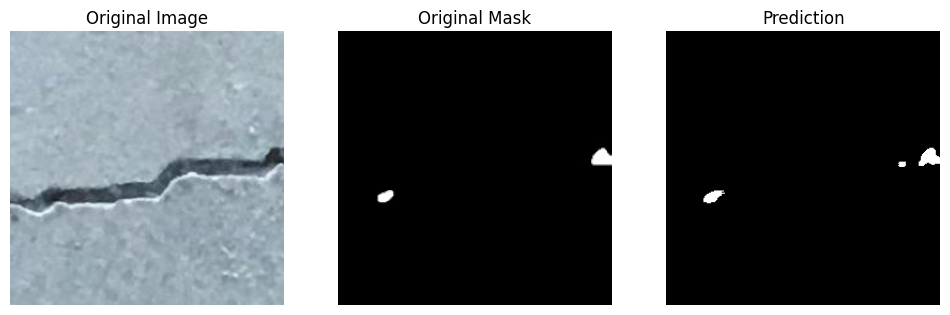

index =  762
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_09851.jpg
1/1 [==============================] - 0s 30ms/step


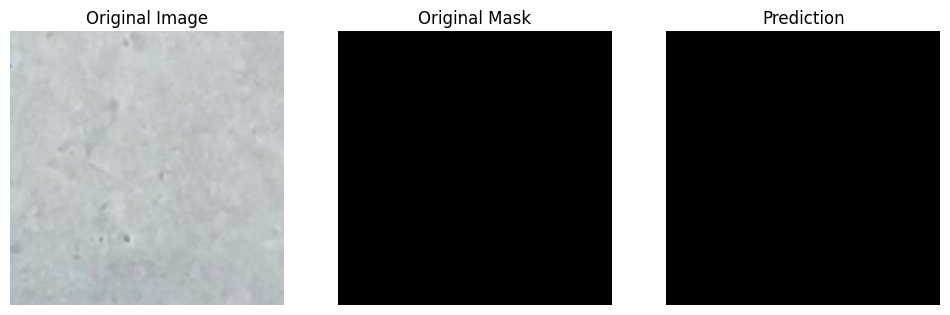

index =  7120
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_00612.jpg
1/1 [==============================] - 0s 29ms/step


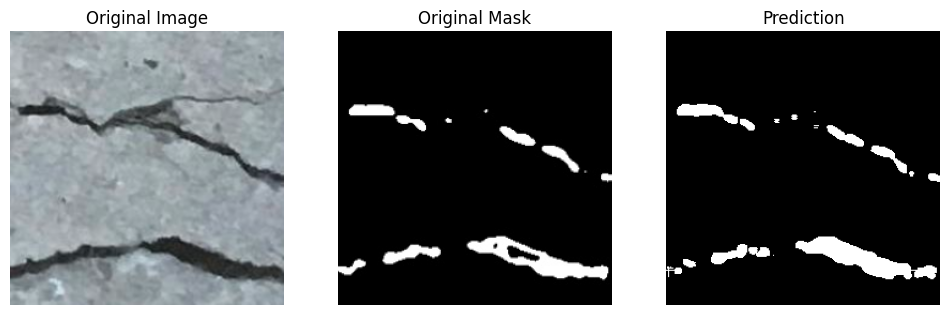

index =  6651
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_14664.jpg
1/1 [==============================] - 0s 33ms/step


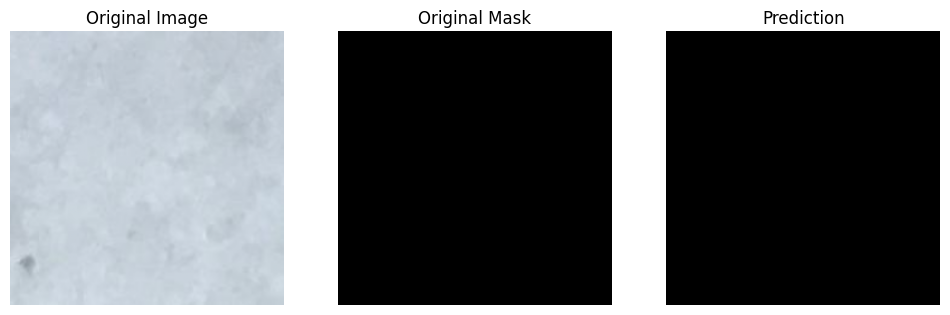

index =  232
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/p_11443_1.jpg
1/1 [==============================] - 0s 31ms/step


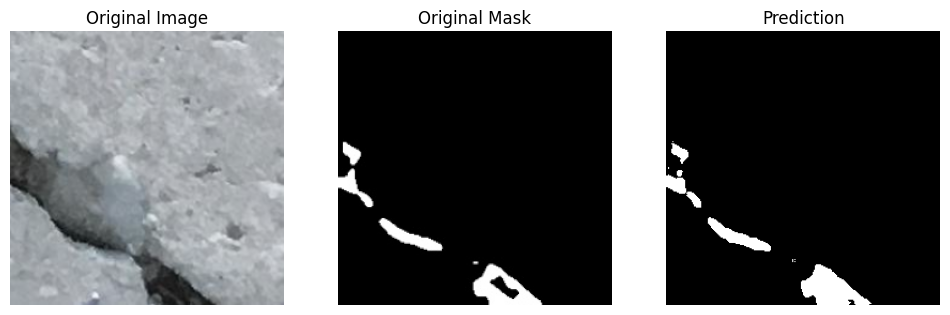

index =  6197
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_16174.jpg
1/1 [==============================] - 0s 39ms/step


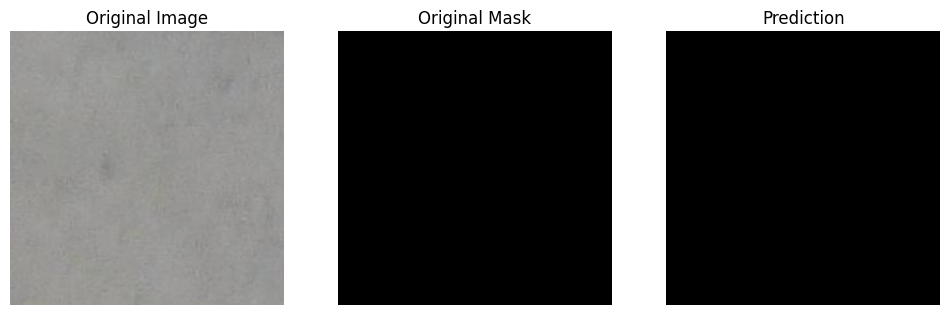

index =  6727
name =  /home/philippe/development/python/concrete_cracks_semantic_segmentation/data_unet/image/n_19896.jpg
1/1 [==============================] - 0s 32ms/step


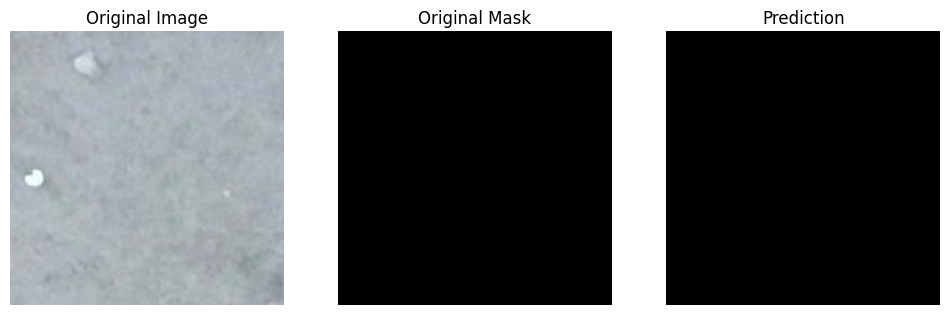

In [33]:
for _ in range(50):
    index = np.random.randint(1, len(unet_test_df.index))
    print('index = ', index)
    print('name = ', unet_test_df['unet_fullpaths_image'].iloc[index])
    
    img = cv2.imread(unet_test_df['unet_fullpaths_image'].iloc[index]) #,  cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))
    img = img / 255
    img = img[np.newaxis, :, :]

    predicted_img = unet_model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img)) #, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(unet_test_df['unet_fullpaths_mask'].iloc[index])), cmap='gray') #, vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    predicted_img = np.squeeze(predicted_img)
    predicted_img_threshold = 0.5
    predicted_img[predicted_img > predicted_img_threshold] = 1
    predicted_img[predicted_img <= predicted_img_threshold] = 0

    plt.imshow(predicted_img, cmap='gray', vmin=0, vmax=1)
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()



### Save the model

In [34]:
unet_model.save('./unet_model_1_2')

INFO:tensorflow:Assets written to: ./unet_model_1_2/assets


INFO:tensorflow:Assets written to: ./unet_model_1_2/assets


### Load the model

In [ ]:
#unet_model = keras.models.load_model('./unet_model_1', custom_objects = {"dice_loss": dice_loss, "iou_coef": iou_coef, "dice_coef": dice_coef})

<a id="crack_detection_2"></a>
# Semantic segmentation

In [35]:
def semantic_segmentation(input_image, height=100, width=100, height_src=unet_image_height, 
                            width_src=unet_image_width, debug=False, predicted_threshold = 0.75):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            shape_ini = a.shape # Save shape of the tile
            a = cv2.resize(a, (height_src, width_src)) # Resize the shape of the tile to the shape of the input layer
            mask_pred = np.zeros_like(a, dtype=np.uint16)
            mask_pred = np.squeeze(unet_model.predict(np.array(a).reshape(1,height_src, width_src,3)/255.0, verbose=0))
            mask_pred_2 = np.stack((mask_pred,)*3, axis=-1).astype(np.uint8)    
            predicted_img_threshold = predicted_threshold
            mask_pred_2[mask_pred_2 > predicted_img_threshold] = 1
            mask_pred_2[mask_pred_2 <= predicted_img_threshold] = 0
            mask_pred_2 = mask_pred_2 * 255
            mask_pred_2[np.where((mask_pred_2==[255, 255, 255]).all(axis=2))] = [255, 0, 0]
            if debug == True:
               print('mask_pred_2.shape: ', mask_pred_2.shape)
               plt.imshow(mask_pred_2)
               plt.show()
            add_img = cv2.addWeighted(a, 0.6, mask_pred_2, 0.4, 0)
            output_image[i:i+height, j:j+width,:] = cv2.resize(add_img, (shape_ini[1], shape_ini[0])) # reshape the tile to its initial shape
            k+=1
    plt.figure(figsize = (20,10))
    plt.imshow(output_image, aspect='auto')
    plt.show()

In [44]:
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/large_images/grunge-concrete-cement-wall-cracked-concrete.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/large_images/crack-695010_960_720.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/large_images/3632302149_9670ace43a_b.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/large_images/images_cracks.jpg'
infile = '/home/philippe/development/python//concrete_cracks_semantic_segmentation/large_images/texture-993878_1280.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/large_images/IMG_20230611_174743.jpg'
#infile = '/home/philippe/development/python/concrete_cracks_semantic_segmentation/large_images/IMG_20230611_174749.jpg'
#infile = '/home/philippe/development/python//concrete_cracks_semantic_segmentation/large_imagesIMG_20230611_174756.jpg'

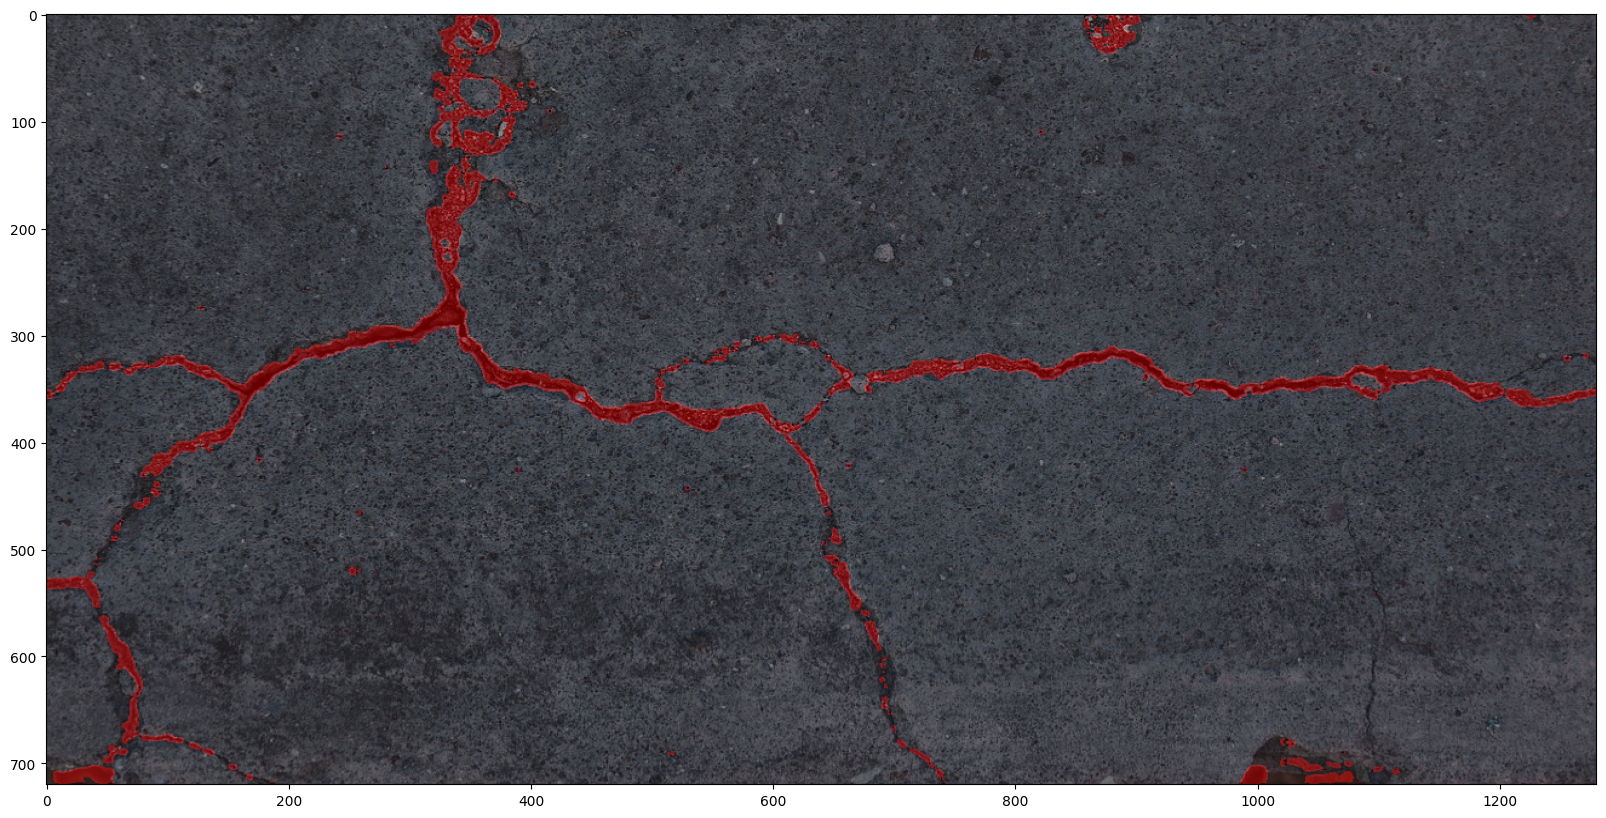

CPU times: user 1.91 s, sys: 95.8 ms, total: 2.01 s
Wall time: 1.87 s


In [46]:
%%time
semantic_segmentation(infile, height=256, width=256, height_src=unet_image_height, 
                            width_src=unet_image_width, debug=False, predicted_threshold = 0.5)

<a id="mask_generation_2"></a>
### Mask generation with U-Net

In [47]:
path_folder = "./data_unet/image/"
img_list = os.listdir(path_folder)

In [48]:
!rm -rf ./data_unet/mask_2/*
!mkdir ./data_unet/mask_2/

mkdir: cannot create directory ‘./data_unet/mask_2/’: File exists


In [49]:
for img in img_list:
    path_in = os.path.join(path_folder, img)
    if img[0] == 'p':
       img = cv2.imread(path_in, cv2.IMREAD_COLOR)
       img = cv2.resize(img, (256, 256))
#       plt.imshow(np.squeeze(img))
#       plt.title("original")
#       plt.show()
       img = img / 255
       img = img[np.newaxis, :, :]
       mask = unet_model.predict(img, verbose=0)
       mask = np.squeeze(mask)
       predicted_img_threshold = 0.5
       mask[mask > predicted_img_threshold] = 1.0
       mask[mask <= predicted_img_threshold] = 0.0
       mask = mask * 255
       mask= np.stack((mask,)*3, axis=-1).astype(np.uint8)
#       print(mask.shape)
    else:
       mask = np.zeros_like(img, dtype=np.uint8)
    mask = cv2.resize(mask, (224, 224))
#    plt.title('Prediction')
#    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
#    plt.show()
    cv2.imwrite("./data_unet/mask_2/" + os.path.basename(path_in), mask)